# ** Importing the Necessary Libraries**

In [10]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l1, l2


from keras.src.applications import InceptionResNetV2
from keras.src.applications.inception_resnet_v2 import preprocess_input

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# ** Creating a Combined Image Dataset with Labels**

In [14]:
data_dir = "Eye Disease dataset"

cataract_df = pd.DataFrame(columns=['filepaths', 'labels'])
diabetic_retinopathy_df = pd.DataFrame(columns=['filepaths', 'labels'])
glaucoma_df = pd.DataFrame(columns=['filepaths', 'labels'])
normal_df = pd.DataFrame(columns=['filepaths', 'labels'])

cataract_label = 'cataract'
diabetic_retinopathy_label = 'diabetic_retinopathy'
glaucoma_label = 'glaucoma'
normal_label = 'normal'


cataract_files = os.listdir(os.path.join(data_dir, "cataract"))
diabetic_retinopathy_files = os.listdir(os.path.join(data_dir, "diabetic_retinopathy"))
glaucoma_files = os.listdir(os.path.join(data_dir, "glaucoma"))
normal_files = os.listdir(os.path.join(data_dir, "normal"))


cataract_df['filepaths'] = [os.path.join(data_dir, "cataract", filename) for filename in cataract_files]
cataract_df['labels'] = cataract_label

diabetic_retinopathy_df['filepaths'] = [os.path.join(data_dir, "diabetic_retinopathy", filename) for filename in diabetic_retinopathy_files]
diabetic_retinopathy_df['labels'] = diabetic_retinopathy_label

glaucoma_df['filepaths'] = [os.path.join(data_dir, "glaucoma", filename) for filename in glaucoma_files]
glaucoma_df['labels'] = glaucoma_label

normal_df['filepaths'] = [os.path.join(data_dir, "normal", filename) for filename in normal_files]
normal_df['labels'] = normal_label

In [20]:
combined_df = pd.concat([cataract_df, diabetic_retinopathy_df], ignore_index=True)
combined_df = pd.concat([combined_df, glaucoma_df], ignore_index=True)
combined_df = pd.concat([combined_df, normal_df], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42)
label_counts = combined_df['labels'].value_counts()

label_counts

labels
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [21]:
combined_df.head()

,filepaths,labels
463,Eye Disease dataset/cataract/_166_7102152.jpg,cataract
2426,Eye Disease dataset/glaucoma/1440_left.jpg,glaucoma
2661,Eye Disease dataset/glaucoma/1429_left.jpg,glaucoma
1483,Eye Disease dataset/diabetic_retinopathy/10391...,diabetic_retinopathy
2860,Eye Disease dataset/glaucoma/1228_left.jpg,glaucoma


# ** Exploring Data Distribution and Visualizing Images**

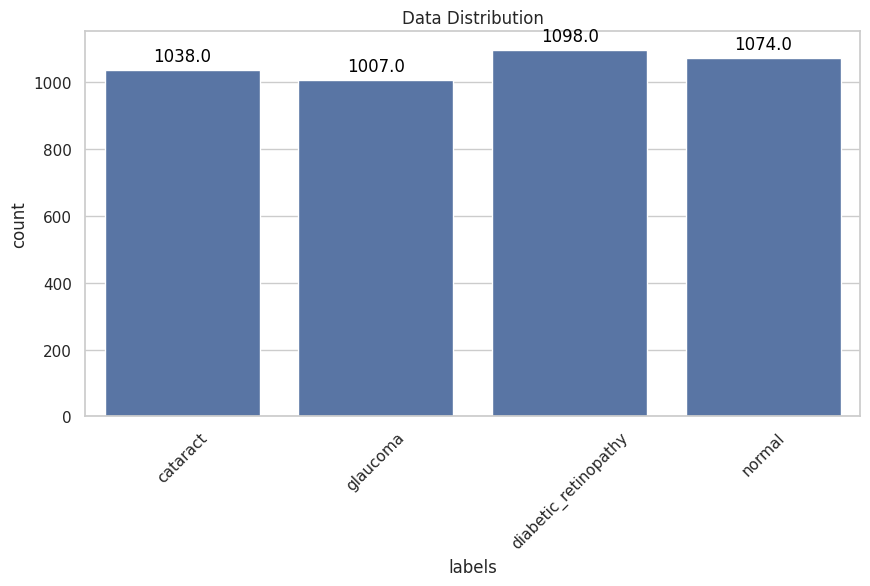

In [24]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.countplot(data=combined_df, x='labels')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()

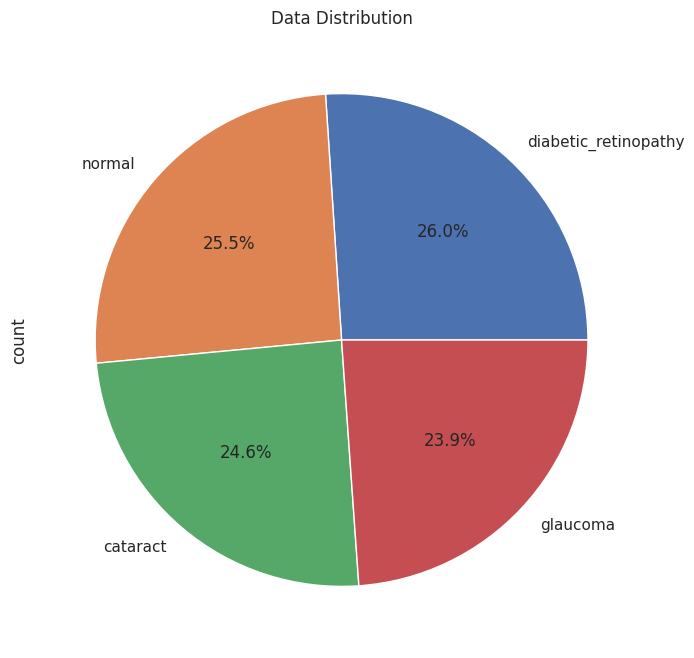

In [25]:
plt.figure(figsize=(10, 8))
combined_df['labels'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

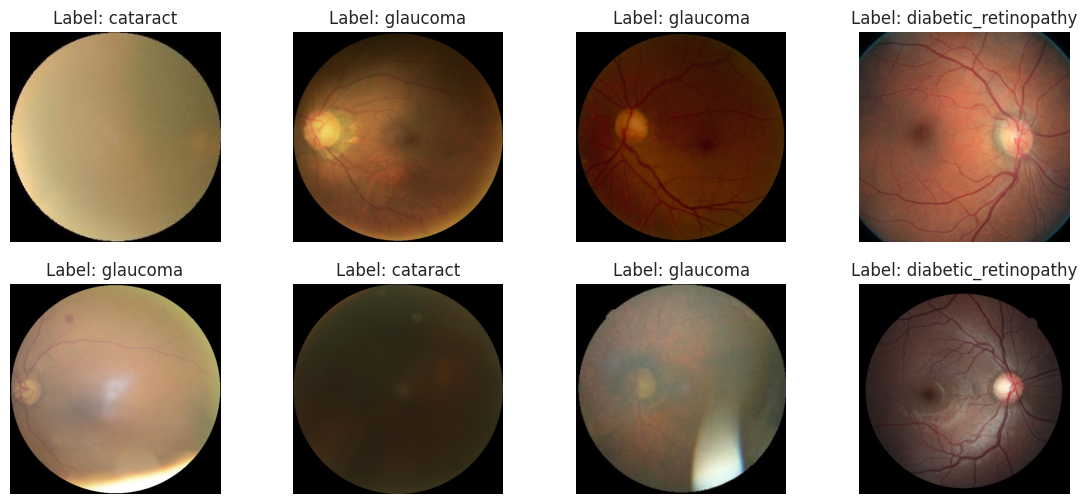

In [26]:
def display_images(df, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            if index < len(df):
                image_path = df.iloc[index]['filepaths']
                label = df.iloc[index]['labels']
                img = Image.open(image_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f'Label: {label}')
                axes[r, c].axis('off')
            else:
                axes[r, c].axis('off')

    plt.show()

rows = 2
cols = 4

display_images(combined_df, rows, cols)